#### Note: 1번 DiscreteREINFORCE, 2번 ContinousREINFORCE와 겹치는 변수 및 함수는 설명이 기재되어있지 않습니다.
#### 따라서 설명이 있는 부분만 보시면, 1번, 2번과의 차이점을 확인할 수 있습니다.

#### REINFORCE with Baseline은 sutton책의 chapter 13의 13.4의 pseudo code를 참조하시면 됩니다. 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

import gym
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# for using sampling with gradient-tracking when selecting an action
from torch.distributions import Categorical

In [14]:
class Policy(nn.Module):

    def __init__(self, state_dim, action_dim, hidden):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, action_dim)
        
    def forward(self, state):
        out = F.relu(self.fc1(state)) 
        out = F.softmax(self.fc2(out), dim=1) 
        return out 

In [15]:
class Baseline(nn.Module):
    '''
        Input: State
        Output: Value
    '''
    def __init__(self, state_dim, action_dim, hidden):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden)
        # Sutton의 13.4를 보시면 baseline은 action에 dependent하지 않으면 어떤 함수를 써도 무관하다고 하는데요.
        # 현재 쓰인 baseline은 state를 input으로 받아 1개의 value만을 구하는 함수로 잡았습니다. 따라서 사실상 value function의 역할을 할 수 있게 설정되었습니다.
        # 13.4의 peudo code 참고.
        self.fc2 = nn.Linear(hidden, 1)  
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = self.fc2(out)
        return out # Baseline value for REINFORCE with Baseline

In [16]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, state_dim, action_dim, hidden, P_learning_rate, B_learning_rate, device, save_mode, model_name, saving_start_epi):
        # environment parameter
        self.gamma = gamma
        self.env = env

        # trainig parameter
        self.device = device
        self.n_epi = n_epi
        self.max_steps = max_steps
        self.plot_freq = plot_freq
        self.frame_cnt = 0

        # network paramter
        self.p_lr = P_learning_rate
        self.b_lr = B_learning_rate
        self.policy = Policy(state_dim, action_dim, hidden).to(self.device)
        self.baseline = Baseline(state_dim, action_dim, hidden).to(self.device)  # baseline 함수의 역할을 하는 neural net 정의
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.p_lr)
        self.base_optimizer = optim.Adam(self.baseline.parameters(), lr=self.b_lr) # optimizer도 추가
        
        # log parameter
        self.avg = []
        self.scores = []
        self.p_losses = []
        self.b_losses = []
        self.save_mode = save_mode
        self.model_name = model_name
        self.saving_start = saving_start_epi
        
    def select_action(self, state):
        prob = self.policy(torch.FloatTensor(state).view(1, -1).to(self.device)) 
        cate_dist = Categorical(prob) 
        action = cate_dist.sample() 
        return action.item(), cate_dist.log_prob(action), prob.detach().cpu().numpy() 
    
    def train(self):
        
        for i_episode in range(1, self.n_epi+1):
            epi_history = []
            rewards = [] 
            score = 0

            state = self.env.reset() 
            for step in range(self.max_steps):
                action, log_prob, prob = self.select_action(state)
                
                # 각 state의 baseline value를 계산합니다.
                # 원래 update함수에 넣으면 깔끔할 것 같은데, 그러기 위해선 state를 걔속 저장하다가 update함수에 넘겨주어야 합니다.
                # 혹시나 다른 환경에서는 한 episode 내의 state를 모두 저장해놓는 것이 용량이 커질 수 있어, 일단 이곳에서 base_value를 구하였습니다. 
                base_value = self.baseline(torch.FloatTensor(state).unsqueeze(0).to(device))
                
                next_state, reward, done, _ = env.step(action)
                
                epi_history.append([log_prob, base_value, reward])
                state = next_state
                score += reward
                self.frame_cnt += 1
                if done: break
                    
            self.scores.append(score)
            loss = self._update_policy(epi_history)
            self.p_losses.append(loss[0]) 
            self.b_losses.append(loss[1])
            if i_episode%self.plot_freq == 0:
                self._plot_status(i_episode, self.p_losses, self.b_losses, self.scores)
                
            if self.save_mode & (i_episode > self.saving_start): self._save_model()
            self.avg.append(np.mean(self.scores[-10:]))
            
    def test(self, model_path):
        ''' 저장된 pt파일을 불러와 test 합니다 '''
        
        self.policy.load_state_dict(torch.load(model_path))
        self.policy.eval()
        
        state = self.env.reset()
        done = False
        score = 0
        accum_frames = []
        while not done:
            accum_frames.append(self.env.render(mode="rgb_array"))
            action, log_prob, prob  = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return accum_frames
    
    def _update_policy(self, epi_history):
        '''
            "기본 REINFORCE"와 "Baseline을 활용한 REINFORCE"와의 핵심 차이점이 있는 함수입니다.
            update 방식이 다르기 때문인데요, 13.4의 pseudo code중에서 Loop for each step의 아래부분에 해당 내용이 있습니다.
        '''
        accum_R = 0
        p_loss = 0
        b_loss = 0
        epi_len = len(epi_history) - 1 
        
        for idx, [log_p, base, r] in enumerate(epi_history[::-1]):
            accum_R = r + (self.gamma*accum_R)  
            delta = (accum_R - base).detach()
            gamma_pow_t = self.gamma**(epi_len-idx) # gamma^t
            
            p_loss += -log_p * gamma_pow_t * delta 
            b_loss += -base * delta 

        ### 이 아래부분 역시, sutton의 책에서는 for문의 안쪽으로 들어가는 것이 올바른 코드입니다.
        ### 다만, 실제로 해보면 매번 backward를 계산해야하기 때문에 너무 계산이 오래걸린다는 단점이 있고요, 학습이 더 잘되는지도 잘 모르겠습니다.
        self.policy_optimizer.zero_grad()
        p_loss.backward()
        self.policy_optimizer.step()

        self.base_optimizer.zero_grad()
        b_loss.backward()
        self.base_optimizer.step()
        
        return [p_loss.item(), b_loss.item()] # 기존에는 loss 한개만 return하였는데, 이제는 policy loss와 critic loss 두 개를 return합니다.
    
    def _save_model(self):
        last_mean = np.mean(self.scores[-10:])
        if  max(self.avg) < last_mean:
            torch.save(self.policy.state_dict(), self.model_name+f'Score_{round(last_mean, 3)}.pt')
    
    def _plot_status(self, i_episode, p_losses, b_losses, score_hist):
        subplot_params = [
            (311, f"Scores in episode_{i_episode}", score_hist),
            (312, f"Policy loss in episode:{i_episode}", p_losses),
            (313, f"Base loss in episode:{i_episode}", b_losses),
        ]

        clear_output(True) 
        plt.figure(figsize=(20, 20), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show()

In [ ]:
device = torch.device(
            "cuda:1" if torch.cuda.is_available() else "cpu"
        )
env_name_list = ["CartPole-v0", "CartPole-v1", "MountainCar-v0", "LunarLander-v2"]
env_name = env_name_list[0]
env = gym.make(env_name)

# 몇 episode 이후부터 저장할 것인지 정하는 변수 입니다.
saving_start_epi = 100

# model을 저장할 폴더를 지정합니다. save_mode 변수로 저장 여부를 결정합니다.
save_mode = False
model_save_folder = './model_save'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
model_name = f"./{model_save_folder}/Discrete_REINFORCE_base_{env_name}_"

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

n_epi = 100000 
max_steps = 1000
gamma = 0.98
plot_freq = 10

# hidden layer의 node 개수를 하나로만 define하고 있는데, 원하시는대로 policy와 critic을 각각 별도로 지정해주어도 됩니다.
hidden = 128 

# 일반적으로 policy의 learning rate을 더 작게할 때 학습이 잘 되었는데요, 이것이 "일반적인" 현상인 것인지 혹은 "환경마다" 다른 현상인지는 아직 확인해보지 못했습니다.
P_learning_rate = 0.001
B_learning_rate = 0.01

In [18]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            P_learning_rate,
            B_learning_rate,
            device, 
            save_mode, 
            model_name, 
            saving_start_epi)

In [ ]:
agent.train() 

In [ ]:
model_path = f"{model_name}Score_200.0.pt"
frames = agent.test(model_path)

import imageio
from IPython.display import Video
imageio.mimwrite('./test1.mp4', frames, fps=30)
Video('./test1.mp4', width=480, height=360)

    CartPole-v0
    
    n_epi = 100000 
    max_steps = 1000
    gamma = 0.98
    plot_freq = 10

    hidden = 128 

    P_learning_rate = 0.0001
    B_learning_rate = 0.001

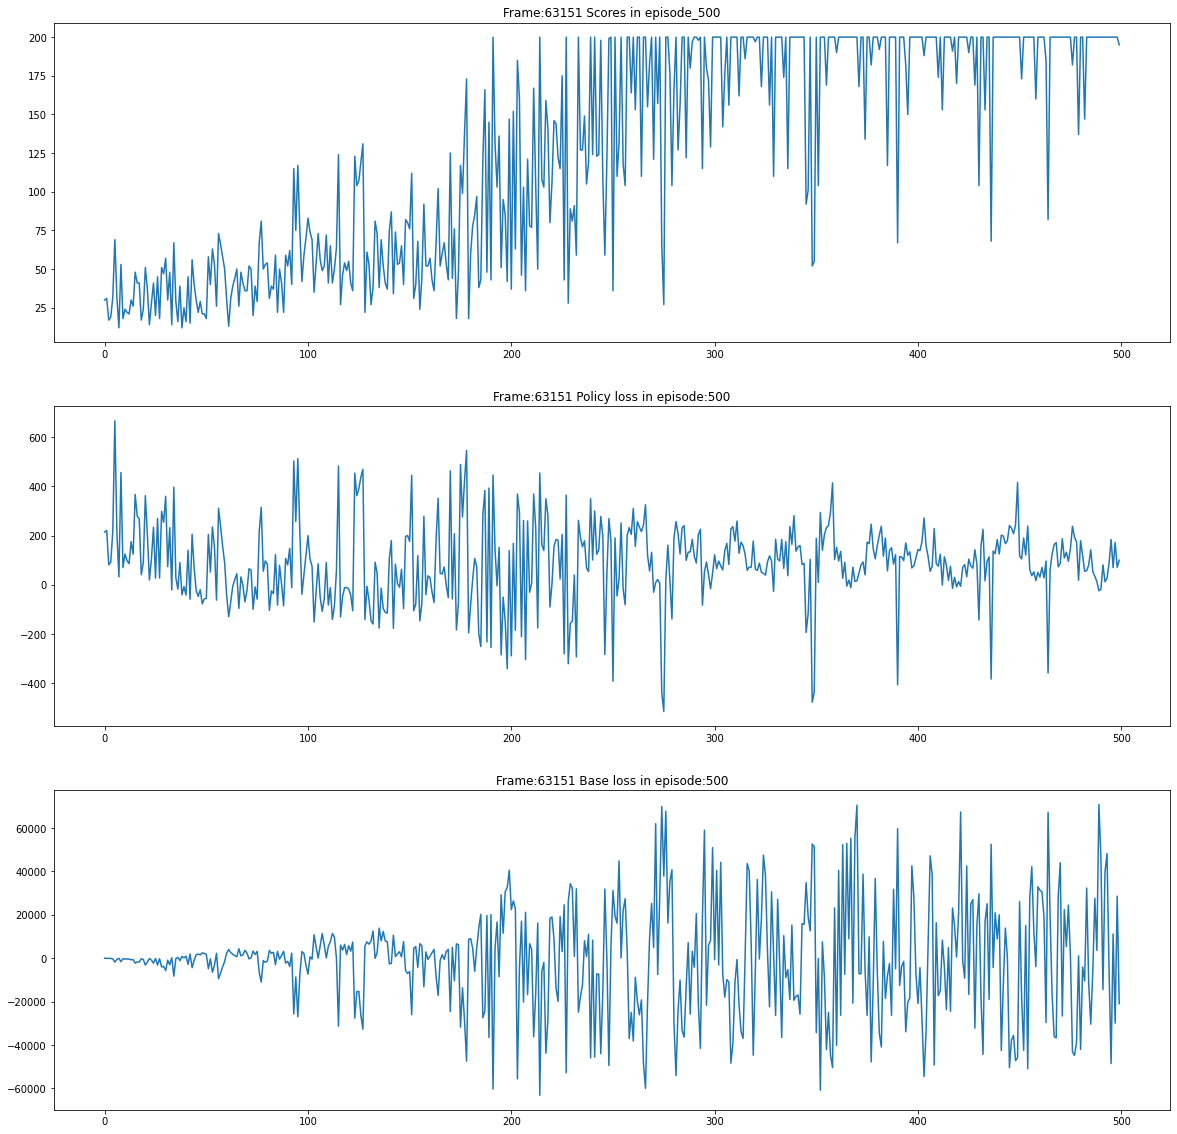

#### 아래의 모든 결과는 LunarLander-v2에서 실행한 결과입니다.
#### LunarLander는 일반적으로 한 episode 당 받은 총 reward가 200점 이상이 되면 학습이 된 것으로 판단합니다.


    n_epi = 100000 
    max_steps = 1000
    gamma = 0.999
    plot_freq = 10

    hidden = 64 
    learning_rate = 0.001

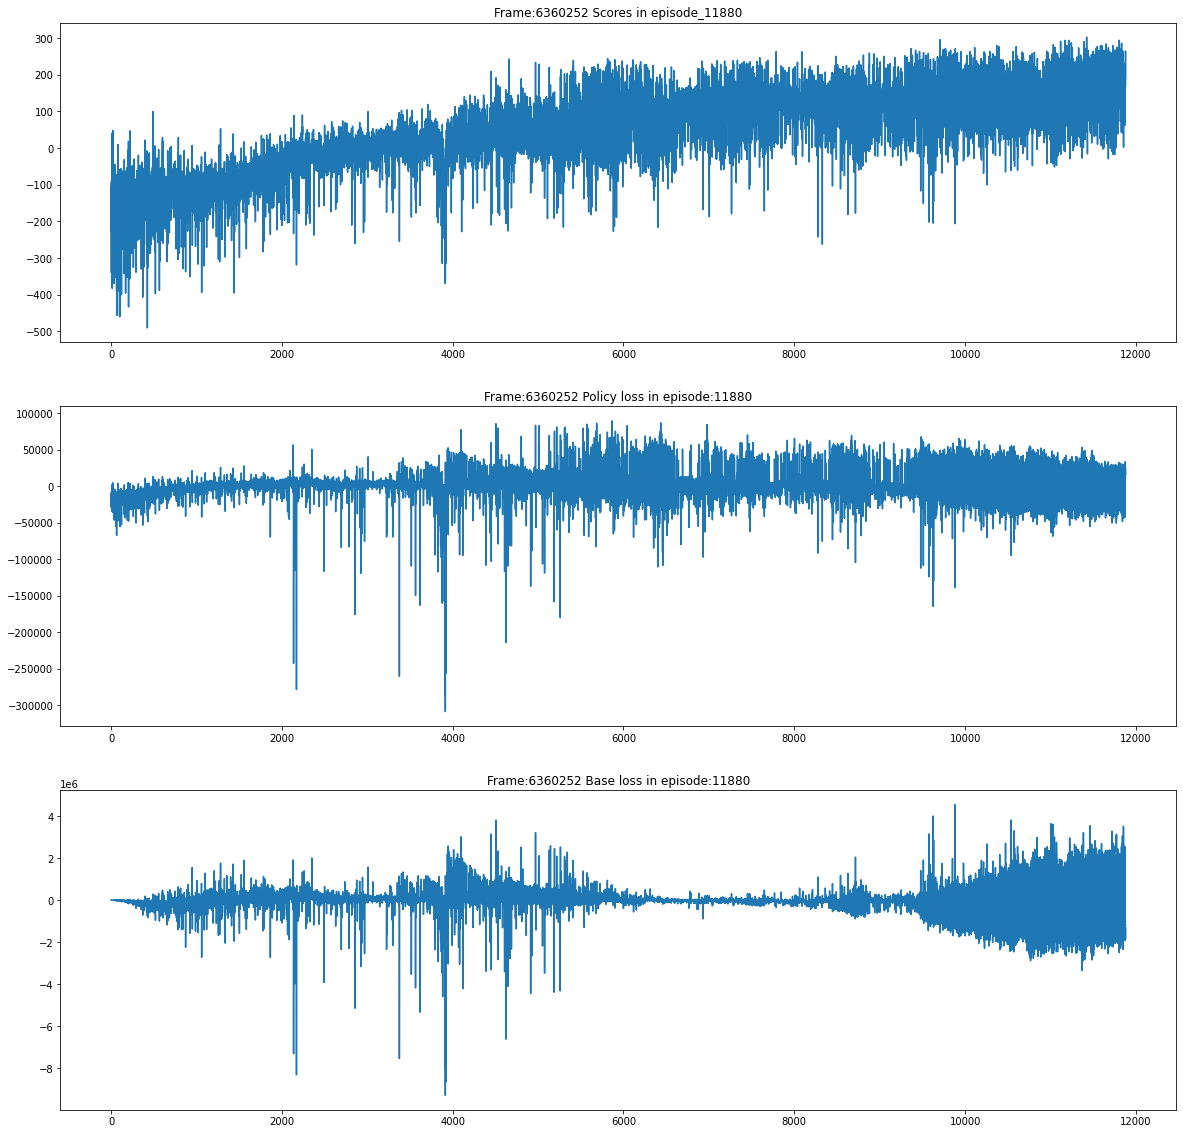

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.98
    plot_freq = 10

    hidden = 128 

    learning_rate = 0.008

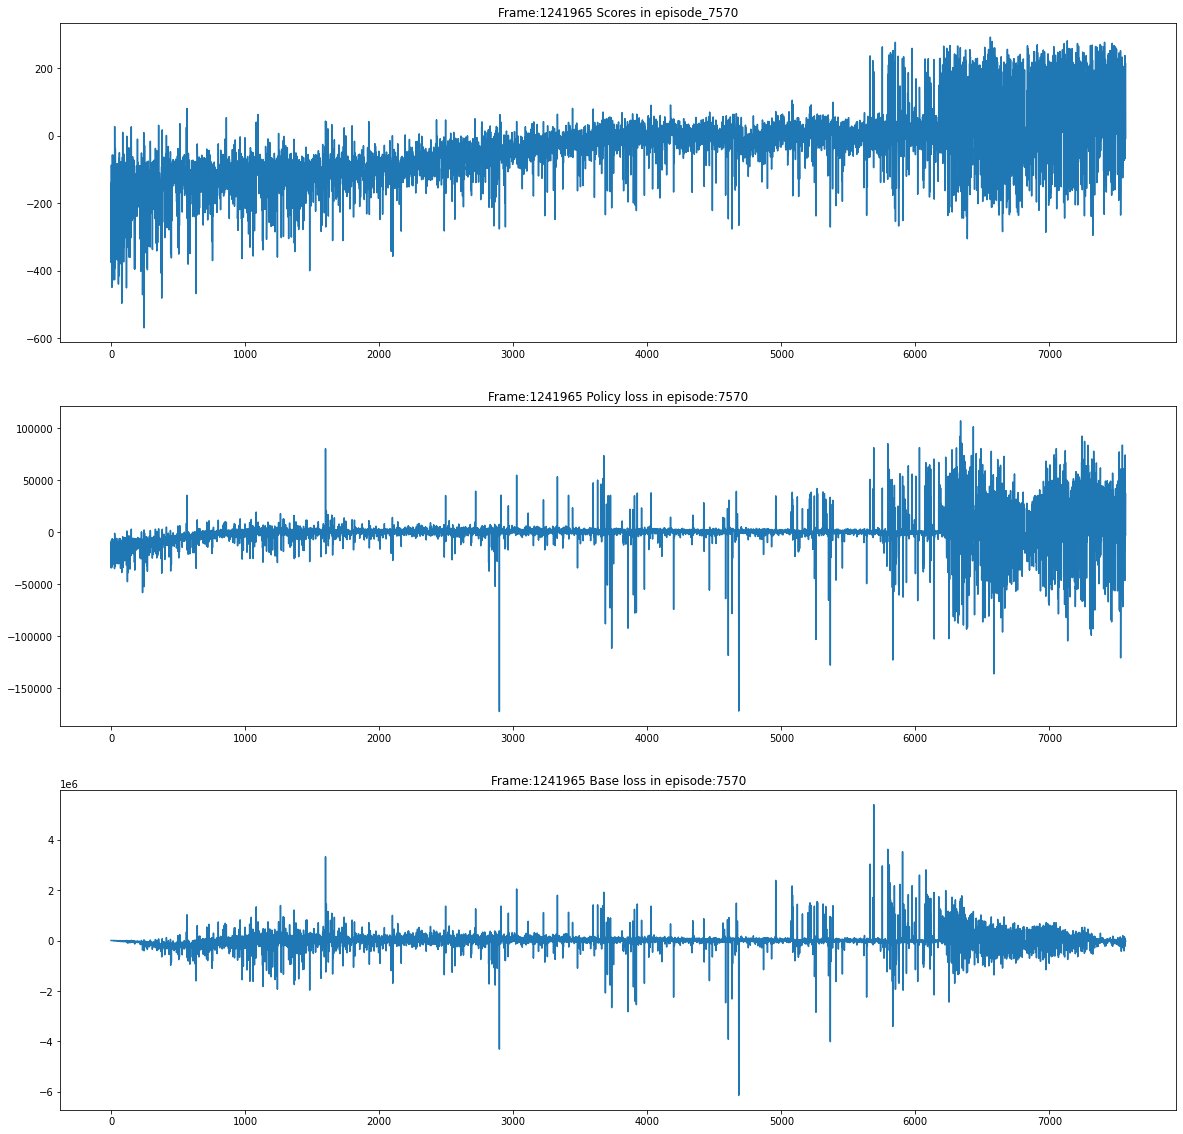

    total training episode = 7570 (total training frames: 1241965). 
    최근 500개의 score를 plot한 것.

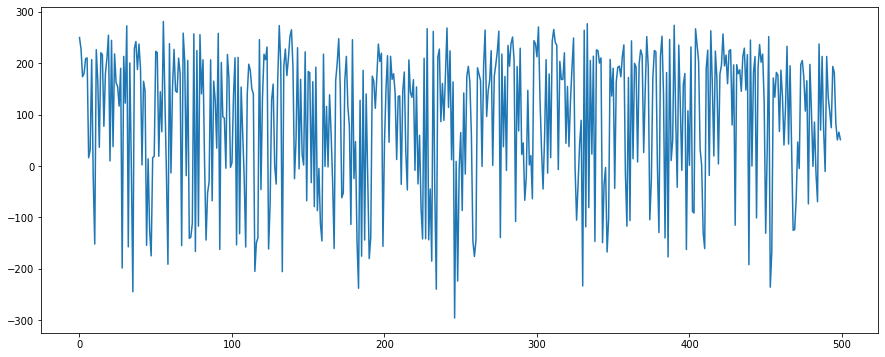

    n_epi = 100000 
    max_steps = 1000
    gamma = 0.99
    plot_freq = 10

    hidden = 128 
    learning_rate = 0.006

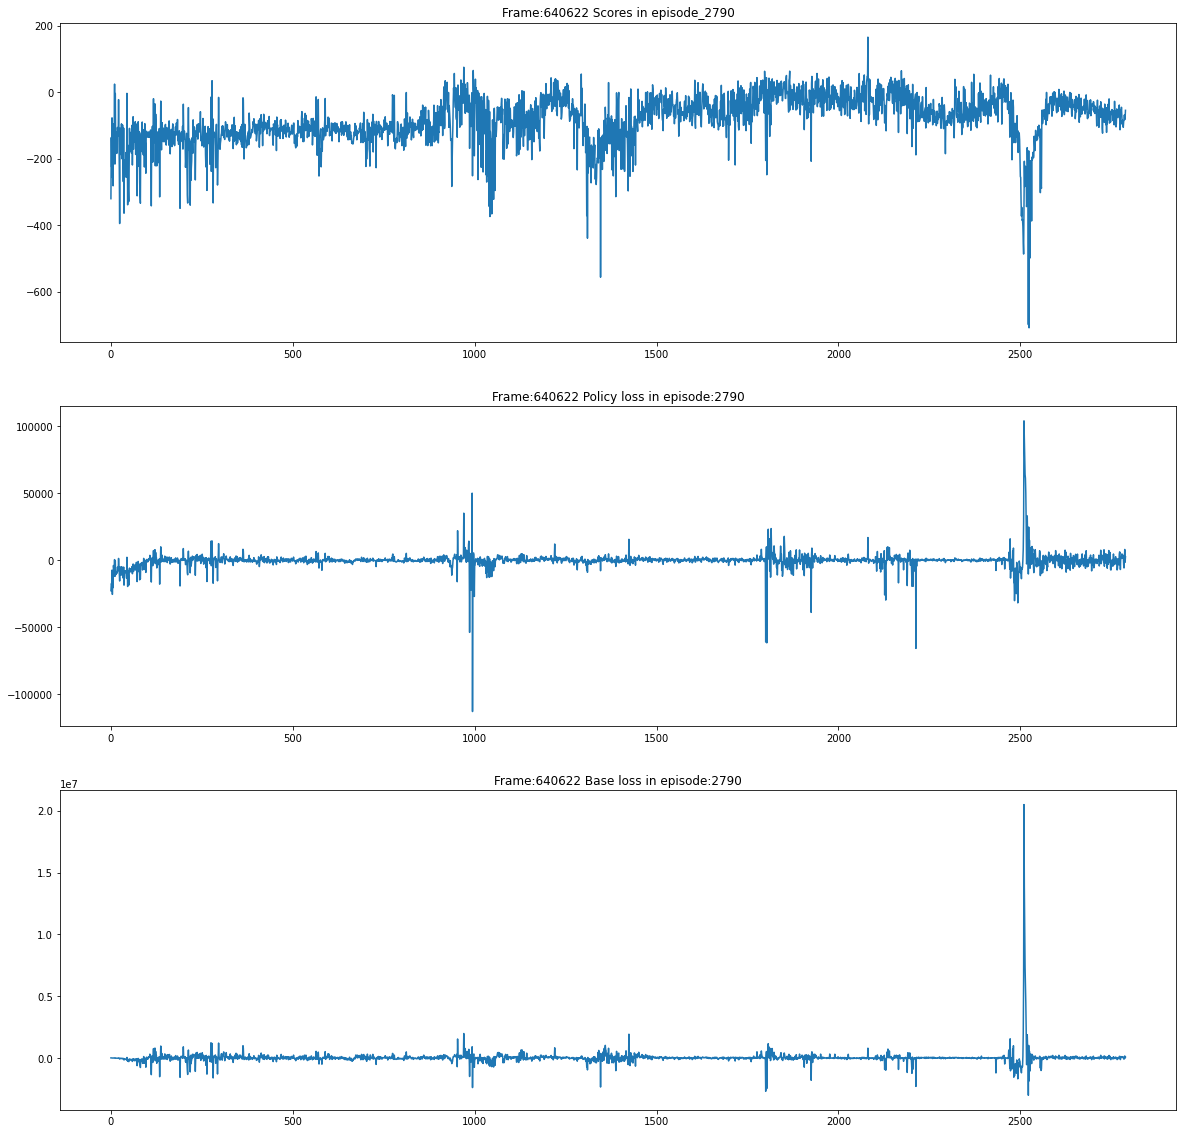